<a href="https://colab.research.google.com/github/alizul01/machine-learning-course/blob/main/praktikum_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library Area

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

tfds.disable_progress_bar()

## Method Area

In [2]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Dataset

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"...the first film I had to walk out on. And it was the cast and crew pre-screening (Not that I was involved, I hasten to add). I made it through the first hour, so I reckon I'm just qualified to comment, but that was my limit.<br /><br />Like other comments here, how did this get through any kind of QA. An accumulation of the very worst in dialogue, the epitome of wooden acting, awful casting, all wrapped together without a plot.<br /><br />Tara Fitzgerald's casting was bizarre, almost comic. She possesses the worst Russian accent in movie history.<br /><br />As I left the screening, the director and producers were drinking in a bar outside the cinema. They obviously couldn't sit through it again either.<br /><br />"
 b'I have to say, as a BSG fan I wasn\'t exactly sure what I\'d think of this show. I saw it on the big screen at the Arclight cinema tonight (as part of the Paley Center screenings), and the cast and film makers spoke after-wards. Ron Moore said they \'wanted t

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 2, 86, 20, ...,  0,  0,  0],
       [10, 26,  6, ...,  1,  6, 70],
       [ 1,  3, 10, ...,  0,  0,  0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"...the first film I had to walk out on. And it was the cast and crew pre-screening (Not that I was involved, I hasten to add). I made it through the first hour, so I reckon I'm just qualified to comment, but that was my limit.<br /><br />Like other comments here, how did this get through any kind of QA. An accumulation of the very worst in dialogue, the epitome of wooden acting, awful casting, all wrapped together without a plot.<br /><br />Tara Fitzgerald's casting was bizarre, almost comic. She possesses the worst Russian accent in movie history.<br /><br />As I left the screening, the director and producers were drinking in a bar outside the cinema. They obviously couldn't sit through it again either.<br /><br />"
Round-trip:  the first film i had to [UNK] out on and it was the cast and [UNK] [UNK] not that i was involved i [UNK] to add i made it through the first hour so i [UNK] im just [UNK] to comment but that was my [UNK] br like other comments here how did this get

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[-0.01548922]


In [12]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 63ms/step
[-0.01548922]


In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [14]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 50s 103ms/step - loss: 0.6173 - accuracy: 0.5971 - val_loss: 0.4780 - val_accuracy: 0.7995
Epoch 2/10
391/391 [==============================] - 26s 66ms/step - loss: 0.4008 - accuracy: 0.8176 - val_loss: 0.3797 - val_accuracy: 0.8203
Epoch 3/10
391/391 [==============================] - 38s 96ms/step - loss: 0.3423 - accuracy: 0.8496 - val_loss: 0.3408 - val_accuracy: 0.8479
Epoch 4/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3271 - accuracy: 0.8578 - val_loss: 0.3304 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3139 - accuracy: 0.8664 - val_loss: 0.3268 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3094 - accuracy: 0.8676 - val_loss: 0.3253 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3092 - accuracy: 0.8673 - val_loss: 0.3275 - val_accuracy

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3156 - accuracy: 0.8594
Test Loss: 0.3156047761440277
Test Accuracy: 0.8593599796295166


(0.0, 0.6330855429172516)

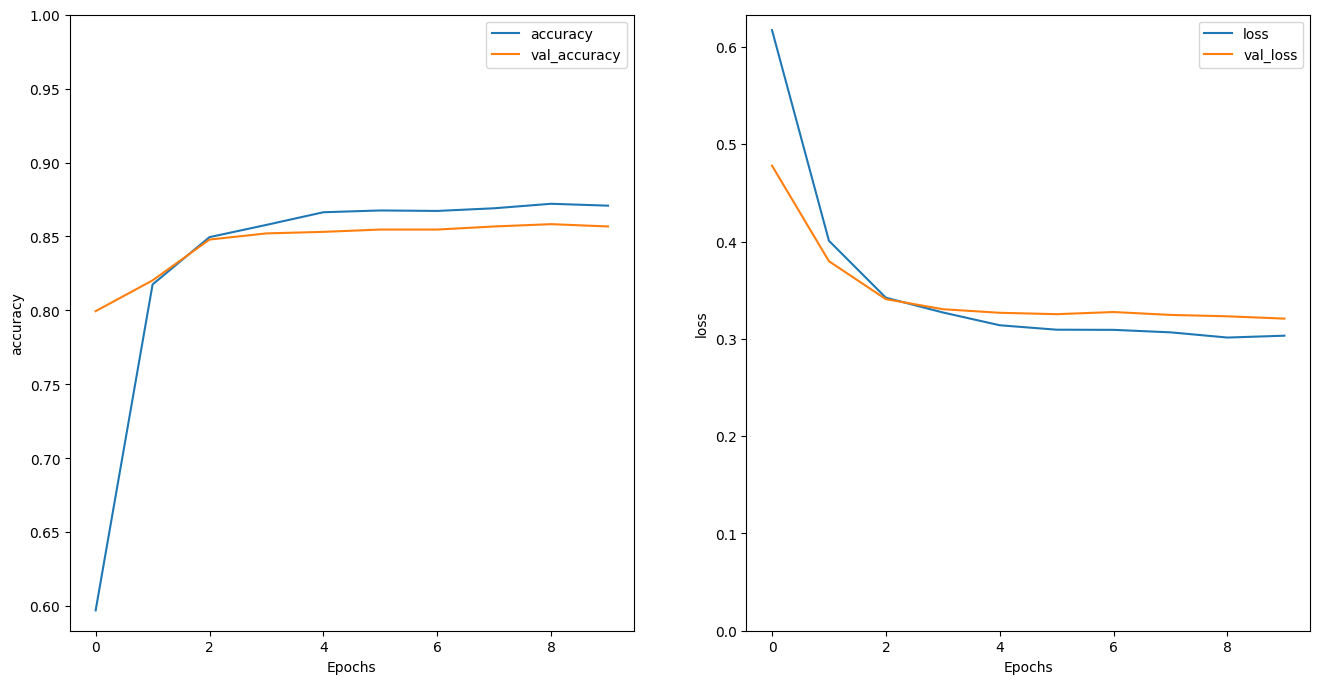

In [16]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [19]:
sample_text = ('The movie was cool. The animation and the graphics '
 'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 82s 157ms/step - loss: 0.6312 - accuracy: 0.5868 - val_loss: 0.5184 - val_accuracy: 0.7557
Epoch 2/10
391/391 [==============================] - 50s 127ms/step - loss: 0.4211 - accuracy: 0.8116 - val_loss: 0.3809 - val_accuracy: 0.8370
Epoch 3/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3543 - accuracy: 0.8474 - val_loss: 0.3462 - val_accuracy: 0.8328
Epoch 4/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3297 - accuracy: 0.8600 - val_loss: 0.3271 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3155 - accuracy: 0.8653 - val_loss: 0.3208 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3073 - accuracy: 0.8698 - val_loss: 0.3219 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3024 - accuracy: 0.8717 - val_loss: 0.3389 - val_ac

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 52ms/step - loss: 0.3294 - accuracy: 0.8392
Test Loss: 0.3293934762477875
Test Accuracy: 0.8392000198364258


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics ' 'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.6456974]]


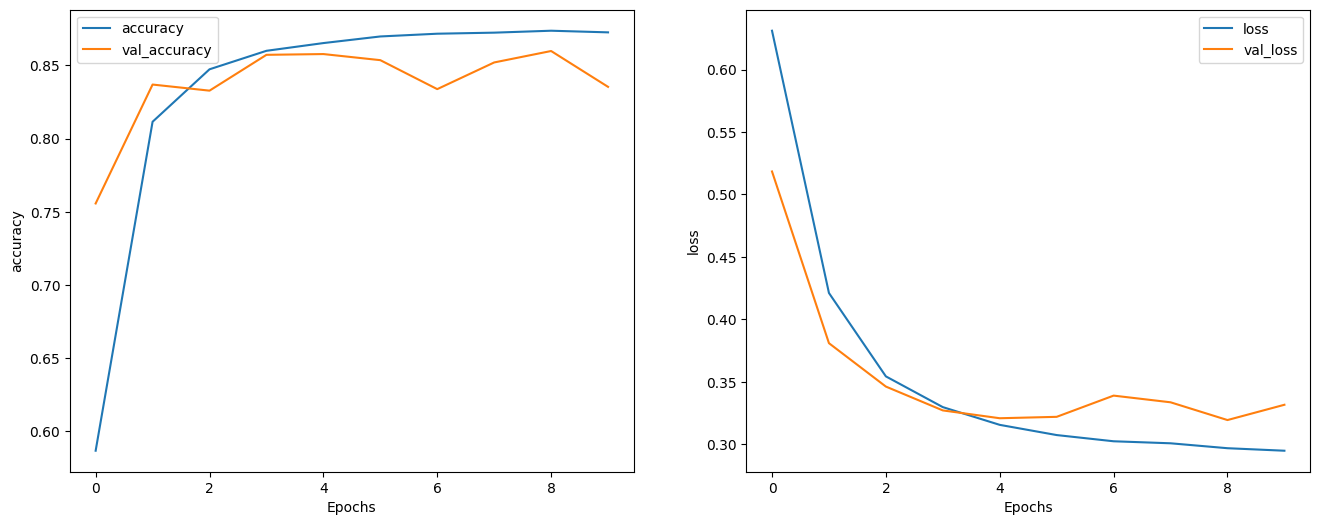

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')